# Sweet Lift Taxi Company 

Sweet Lift Taxi, a leading transportation service provider, has amassed a wealth of historical data on taxi orders at various airports. Leveraging this data is crucial for optimizing service delivery, particularly during peak hours when demand can be highly variable. To address this need, a predictive model will be developed to accurately forecast the number of taxi orders for the upcoming hour. This model aims to attract more drivers during high-demand periods, ensuring that the service remains efficient and reliable.

The primary objective of this project is to create a robust predictive model that achieves a Root Mean Squared Error (RMSE) of no more than 48 on the test set. This level of accuracy will enable the company to anticipate demand fluctuations and make informed decisions about resource allocation, ultimately enhancing both driver satisfaction and customer experience.

The project will involve a comprehensive analysis of the historical data, exploration of various machine learning algorithms, and rigorous performance evaluation to identify the best predictive model. The approach will include data preprocessing, feature engineering, model training, and validation to ensure that the final model meets the specified performance criteria.

## Data Description


The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Setup

### Library Imports

In [4]:
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from pprint import pprint

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# statmodels imports
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# # pmdarima imports
# from pmdarima import auto_arima

### Data Import

In [5]:
try:
    df = pd.read_csv('./data/taxi.csv')
except FileNoteFoundError as e:
    print(f'The following error occurred: {e}')
else:
    print('Dataset loaded successfully')

Dataset loaded successfully


## Data Preparation

### Data Preprocessing

In [6]:
# Inspect data

df.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [7]:
# Print general info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [8]:
# Look for missing and duplicated values

for col in df.columns:
    print(f'Column: {col}')
    print(f'Missing Values: {df[col].isna().sum()}')
    print(f'Duplicated Values: {df[col].duplicated().sum()}')
    print()

Column: datetime
Missing Values: 0
Duplicated Values: 0

Column: num_orders
Missing Values: 0
Duplicated Values: 26415



**Considerations**

The dataset has been checked for missing and duplicate data. There is no missing data throughout the entire dataset. Regarding duplicate values, the `num_orders` column contains some duplicates, while the `datetime` column does not. No action will be taken to address the duplicates in the `num_orders` column, as similar values in this column do not impact the data since several days can have the same number of orders.

In [9]:
# Convert every value in 'datetime' col is of 'datetime' type
df['datetime'] = pd.to_datetime(df['datetime'])

# Set the index to datetime, sort the index
df.set_index('datetime', drop=True, inplace=True)
df.sort_index(inplace=True)

# Resample the data
data = df.resample('1H').mean()

In [10]:
# Round the number of orders

data['num_orders'] = data['num_orders'].round()

### Feature Engineering

In [11]:
# Function to add features to data

def make_features(dataset, max_lag=11, rolling_mean_size=8):
    """
    Add lagged features, rolling mean, and date-time features to the dataset.

    Parameters:
    -----------
    dataset : pandas.DataFrame
        The input DataFrame containing a datetime index and 'num_orders' column.
    max_lag : int, optional (default=6)
        The maximum number of lagged features to create.
    rolling_mean_size : int, optional (default=8)
        The window size for calculating the rolling mean of 'num_orders'.

    Returns:
    --------
    pandas.DataFrame
        The input dataset with added features:
        - Lagged features ('lag_1' to 'lag_max_lag')
        - Rolling mean feature ('moving_avg')
        - Date-time features ('year', 'month', 'day_of_week', 'day', 'hour')
    """

    # Create date-time features
    dataset[['month', 'day_of_week', 'day', 'hour']] = pd.DataFrame({
        'month': dataset.index.month,
        'day_of_week': dataset.index.dayofweek,
        'day': dataset.index.day,
        'hour': dataset.index.hour
    }, index=dataset.index)
    
    # Create rolling mean feature
    dataset['moving_avg'] = dataset['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    # Create lagged features
    for lag in range(1, max_lag + 1):
        dataset[f'lag_{lag}'] = dataset['num_orders'].shift(lag)
    
    return dataset

In [12]:
# Add features to data
make_features(data)

# Drop rows with NaN values created by shifting and rolling
data = data.dropna()

In [13]:
# Observe data

data

,num_orders,month,day_of_week,day,hour,moving_avg,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
datetime,,,,,,,,,,,,,,,,,
2018-03-01 11:00:00,16.0,3,3,1,11,6.500,11.0,12.0,6.0,2.0,2.0,1.0,7.0,11.0,12.0,14.0,21.0
2018-03-01 12:00:00,5.0,3,3,1,12,7.125,16.0,11.0,12.0,6.0,2.0,2.0,1.0,7.0,11.0,12.0,14.0
2018-03-01 13:00:00,5.0,3,3,1,13,6.875,5.0,16.0,11.0,12.0,6.0,2.0,2.0,1.0,7.0,11.0,12.0
2018-03-01 14:00:00,8.0,3,3,1,14,7.375,5.0,5.0,16.0,11.0,12.0,6.0,2.0,2.0,1.0,7.0,11.0
2018-03-01 15:00:00,11.0,3,3,1,15,8.125,8.0,5.0,5.0,16.0,11.0,12.0,6.0,2.0,2.0,1.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,23.0,8,4,31,19,27.875,34.0,36.0,33.0,19.0,22.0,28.0,23.0,28.0,32.0,34.0,30.0
2018-08-31 20:00:00,26.0,8,4,31,20,27.250,23.0,34.0,36.0,33.0,19.0,22.0,28.0,23.0,28.0,32.0,34.0
2018-08-31 21:00:00,26.0,8,4,31,21,27.625,26.0,23.0,34.0,36.0,33.0,19.0,22.0,28.0,23.0,28.0,32.0


## Data Analysis

In [14]:
data.describe()

,num_orders,month,day_of_week,day,hour,moving_avg,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
count,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000
mean,14.086039,5.511691,3.005448,15.874007,11.516232,14.061578,14.080817,14.075142,14.070602,14.065153,14.060386,14.052894,14.046311,14.041317,14.039728,14.037911,14.036322
std,7.513421,1.710857,1.993169,8.835142,6.922172,5.156991,7.507569,7.499684,7.498517,7.498566,7.499560,7.496119,7.489571,7.484263,7.483953,7.482991,7.480768
min,0.000000,3.000000,0.000000,1.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,4.000000,1.000000,8.000000,6.000000,10.500000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
50%,13.000000,6.000000,3.000000,16.000000,12.000000,13.250000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
75%,18.000000,7.000000,5.000000,24.000000,18.000000,16.875000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
max,77.000000,8.000000,6.000000,31.000000,23.000000,39.375000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000


**Observations**

During the months spanning from March 2018 to August 2018, an average of approximately 15 taxi orders were placed per hour. The 25th percentile averaged around 9 orders per hour, and the 75th percentile averaged approximately 18 orders per hour. The highest number of orders placed within a single hour was 77.

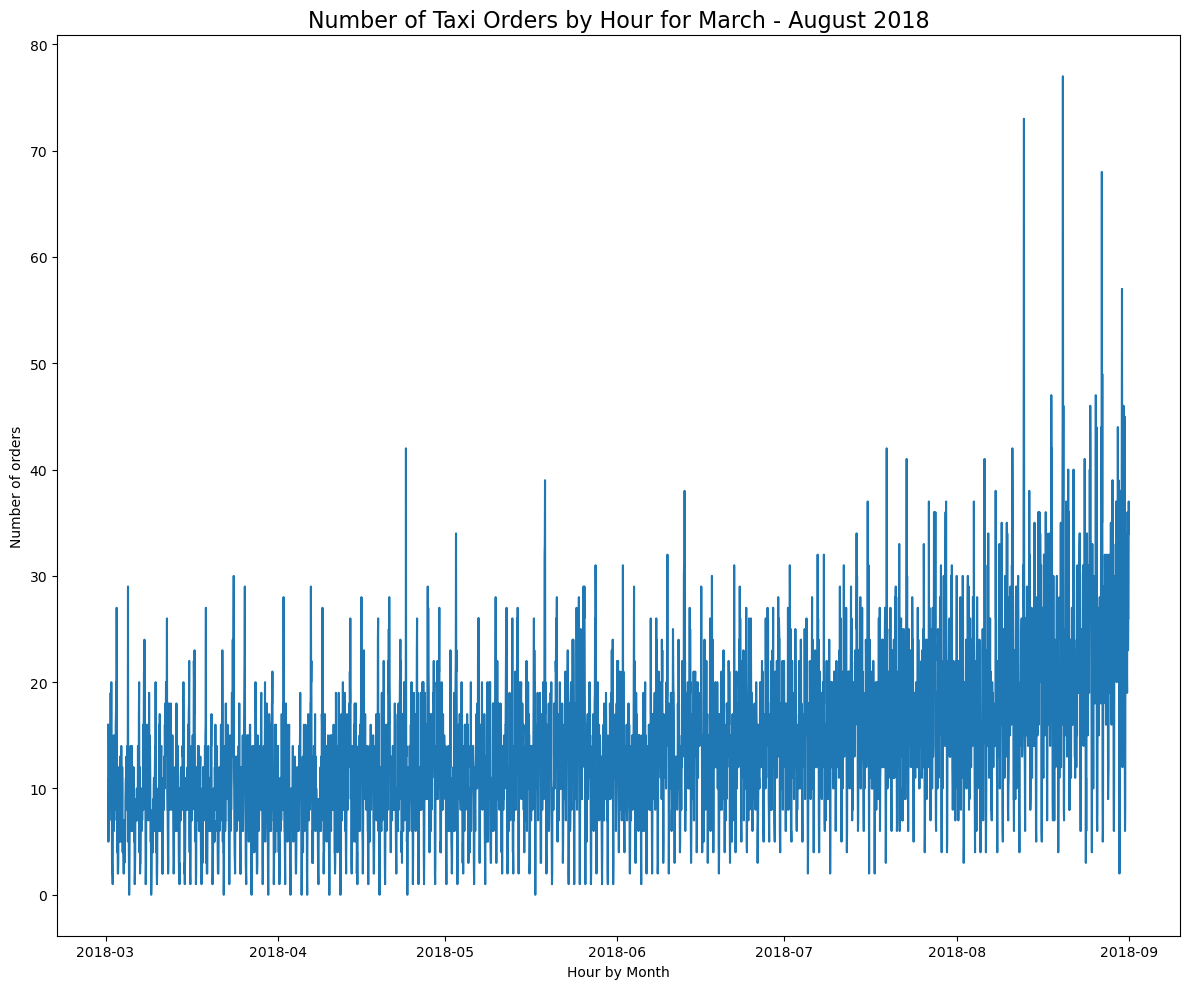

In [15]:
# Visualize entire dataset

plt.figure(figsize=(12, 10))
plt.title('Number of Taxi Orders by Hour for March - August 2018', fontsize=16)
plt.xlabel('Hour by Month')
plt.ylabel('Number of orders')
plt.plot(data['num_orders'])
plt.tight_layout()
plt.show()

In [16]:
# Function to analyze decomposed data

def analyze_decomposed_data(overall_title, start='2018-03-01 00:00:00', end='2018-08-31 23:00:00', dataset=data, col='num_orders'):
    """
    Analyzes and visualizes decomposed time series data.

    Parameters:
    -----------
    - overall_title (str): Title for the entire plot.
    - start (str, optional): Start date/time for the analysis period in 'YYYY-MM-DD HH:MM:SS' format.
      Default is '2018-03-01 00:00:00'.
    - end (str, optional): End date/time for the analysis period in 'YYYY-MM-DD HH:MM:SS' format.
      Default is '2018-08-31 23:00:00'.

    Returns:
    -----------
    None

    This function plots the trend, seasonality, and residuals of a decomposed time series.
    It creates a 3-subplot figure:
    - The first subplot shows the trend component of the decomposed data.
    - The second subplot shows the seasonal component of the decomposed data.
    - The third subplot shows the residual component of the decomposed data.
    """
    
    decomposed = seasonal_decompose(dataset[col])
    
    plt.figure(figsize=(8, 10))

    # Create subsplot & plot the trend, seasonality, residuals
    plt.subplot(311)
    decomposed.trend[start:end].plot(ax=plt.gca())
    plt.title('Trend')

    plt.subplot(312)
    decomposed.seasonal[start:end].plot(ax=plt.gca())
    plt.title('Seasonality')

    plt.subplot(313)
    decomposed.resid[start:end].plot(ax=plt.gca())
    plt.title('Residuals')

    plt.suptitle(overall_title, fontsize=16)
    
    plt.tight_layout()

    plt.show()

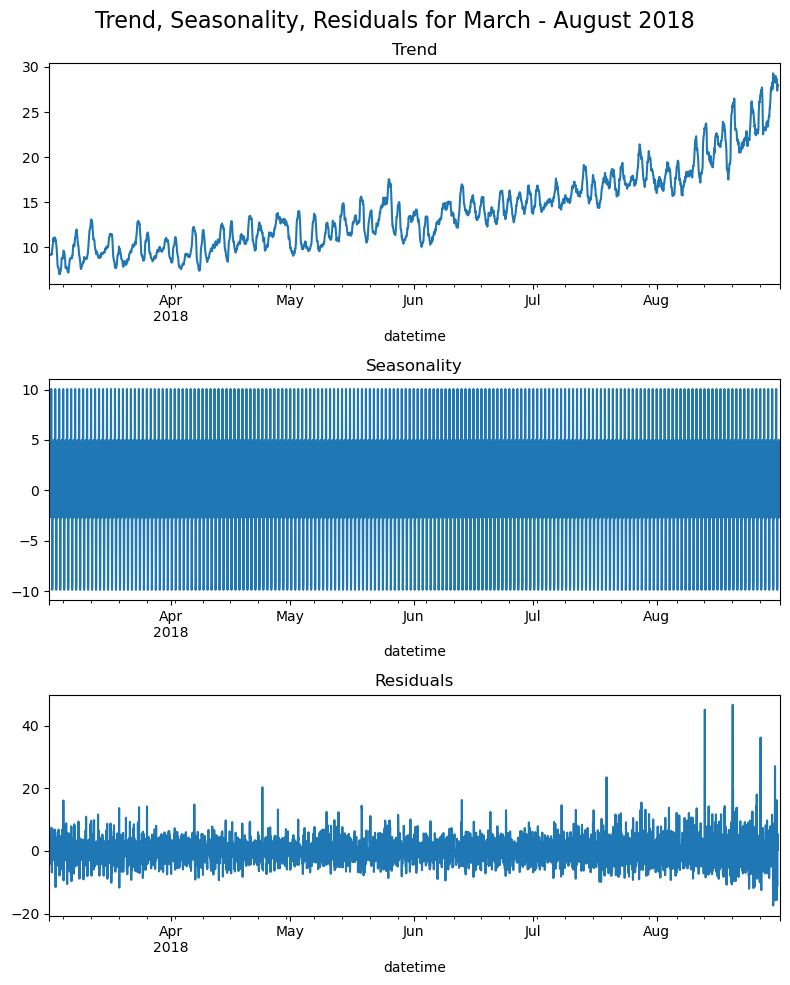

In [17]:
# Analyze Entire Year

analyze_decomposed_data('Trend, Seasonality, Residuals for March - August 2018')

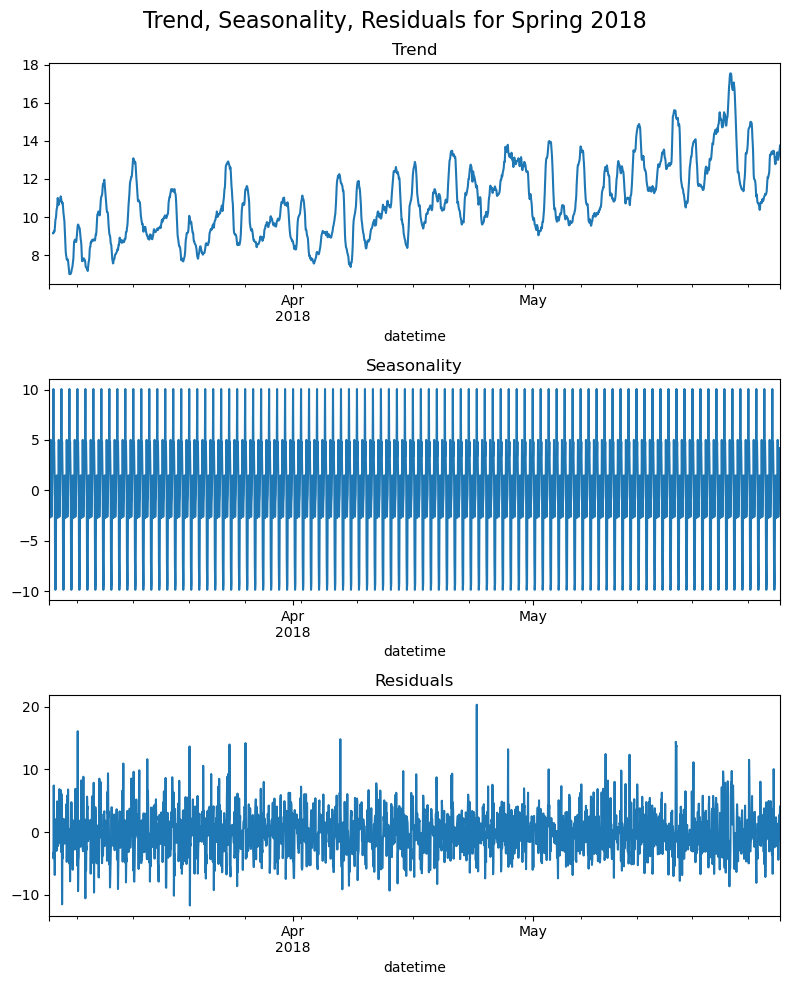

In [18]:
# Analyze Spring Season

analyze_decomposed_data(
    'Trend, Seasonality, Residuals for Spring 2018', '2018-03-01 00:00:00', '2018-05-31 23:00:00'
)

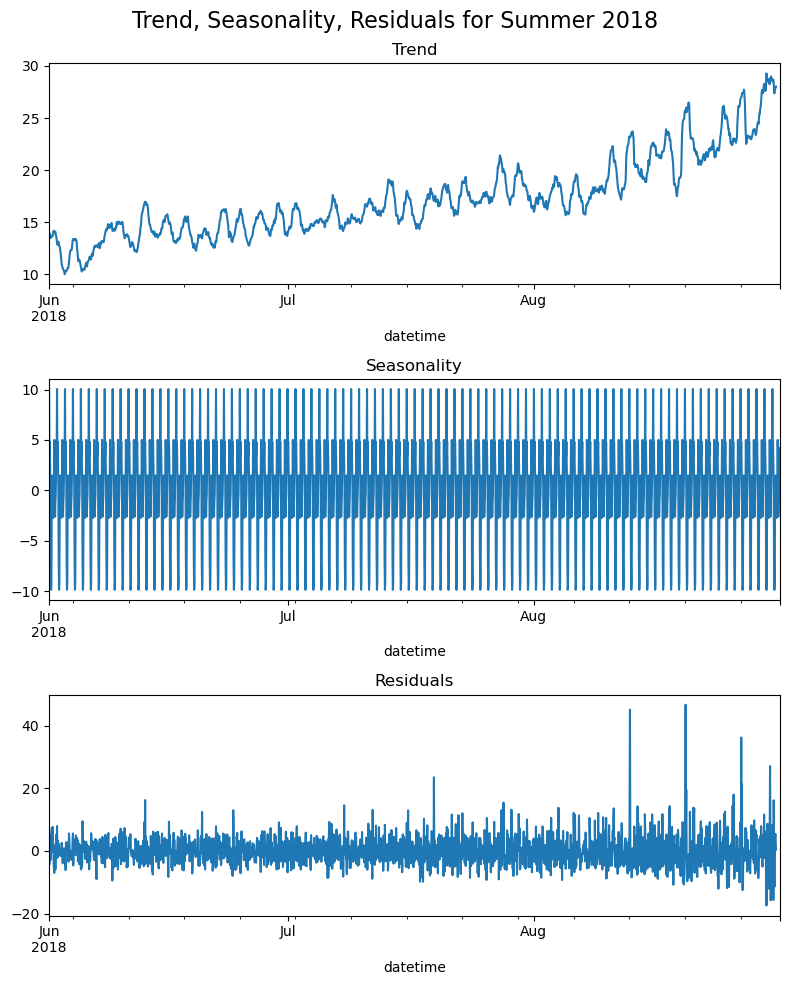

In [19]:
# Analyze Summer Season


analyze_decomposed_data(
    'Trend, Seasonality, Residuals for Summer 2018', '2018-06-01 00:00:00', '2018-08-31 23:00:00',
)

**Observations**

The data indicates an upward trend beginning in March 2018. The trend graph reveals an increase in the number of orders during June, July, and August. This could be attributed to the warmer summer months, which encourage more people to travel for vacations. However, the seasonality graph does not demonstrate any significant or clear seasonal patterns within the dataset.

In [20]:
# Check for correlations between num_orders and features

corr_columns = ['month', 'day', 'day_of_week']

for column in corr_columns:
    corr = data['num_orders'].corr(data[column])
    print(f'Corr between num_orders and {column}: {corr.round(5)}')

Corr between num_orders and month: 0.50847
Corr between num_orders and day: 0.16283
Corr between num_orders and day_of_week: -0.01992


**Findings**

Correlation between `num_orders` and `month`:
- The correlation coefficient of approximately 0.51 reveals a moderate positive correlation between `num_orders` and `month`.
- Interpretation: As the month progresses (from earlier to later months), there is a moderate increase in the number of orders (`num_orders`). This suggests the presence of a seasonal or monthly pattern where certain months experience higher order volumes compared to others.

Correlation between `num_orders` and `day`:
- The correlation coefficient of approximately 0.16 indicates a weak positive correlation between `num_orders` and `day`.
- Interpretation: With an increase in the day of the month (moving from earlier to later days within a month), there is a slight tendency for `num_orders` to rise. However, this correlation is weak, suggesting that the day of the month may not strongly influence the number of orders.

Correlation between num_orders and day_of_week:
- The correlation coefficient of approximately -0.02 shows a very weak negative correlation between `num_orders` and `day_of_week`.
- Interpretation: There is a negligible tendency for `num_orders` to decrease slightly as the day of the week progresses (for example, from Monday to Sunday). However, this correlation is close to zero, indicating an almost negligible relationship between the day of the week and the number of orders.

These findings provide insights into how `num_orders` relate to `month`, `day`, and `day_of_week`, highlighting the varying degrees of correlation observed across these factors.

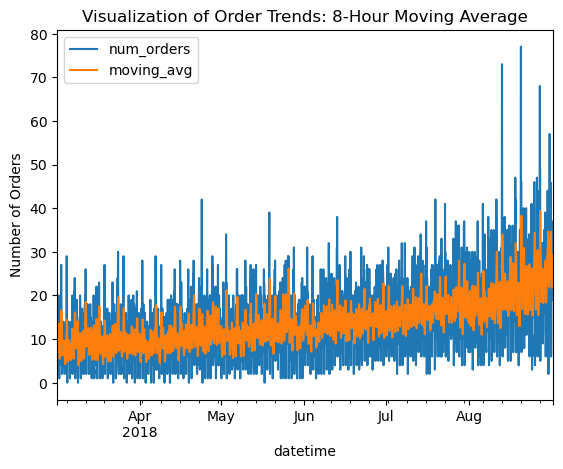

In [21]:
# Smooth out noise and show underlying trends more clearly (8 hours)


# Find rolling average in 12 hour window
data[['num_orders', 'moving_avg']].plot(title='Visualization of Order Trends: 8-Hour Moving Average', ylabel='Number of Orders')
plt.show()

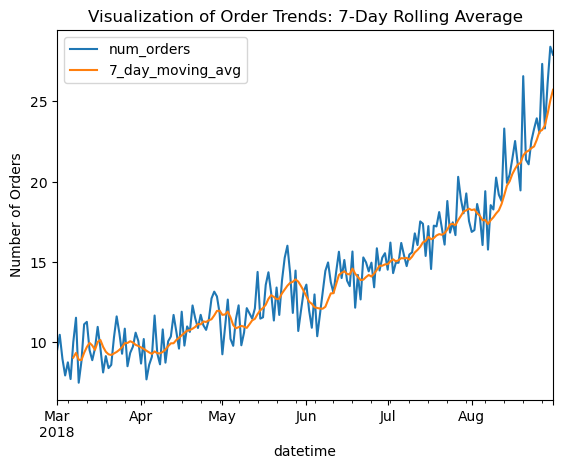

In [22]:
# Smooth out noise and show underlying trends more clearly (7 day)

# Resample original data by 1D
data_day = df.resample('1D').mean()

# Find rolling average in 7 day window
data_day['7_day_moving_avg'] = data_day['num_orders'].rolling(window=7).mean()
data_day[['num_orders', '7_day_moving_avg']].plot(title='Visualization of Order Trends: 7-Day Rolling Average', ylabel='Number of Orders')

plt.show()

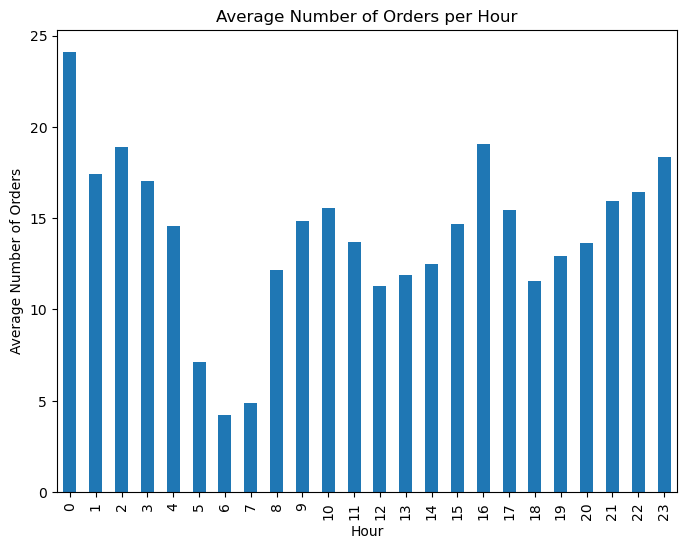

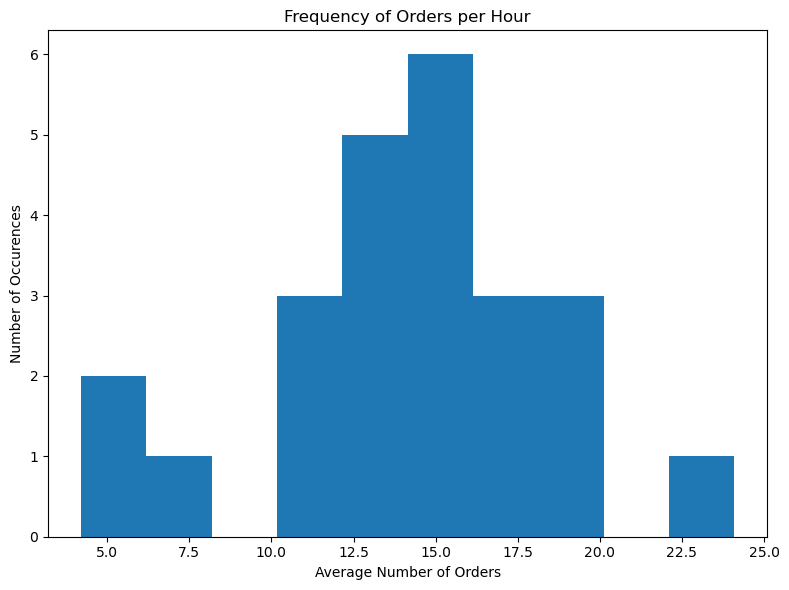

In [23]:
# Calculate the average number of taxi orders per hour

hourly_demand = data.groupby('hour')['num_orders'].mean()

# Plot 1: Bar Plot for Average Number of Orders per Hour
hourly_demand.plot(kind='bar', figsize=(8, 6), title='Average Number of Orders per Hour', xlabel='Hour', ylabel='Average Number of Orders')
plt.show()

# Plot 2: Histogram for Frequency of Orders per Hour
hourly_demand.plot(kind='hist', figsize=(8, 6), title='Frequency of Orders per Hour')
plt.xlabel('Average Number of Orders')
plt.ylabel('Number of Occurences')


plt.tight_layout()
plt.show()

**Observations**

Upon examining both the histogram depicting the frequency distribution of the average number of orders and the bar graph illustrating average order counts by hour, noticeable variations in the data across different hours of the day become apparent.

The peak hours for taxi orders to the airport were observed to be from noon to late afternoon (around 5 pm), followed by a slight decline (between 6 and 8 pm), and then another peak in the late night and early morning hours (between midnight and 3 am).

This pattern likely reflects the scheduling of flights, with a concentration of departures in the early morning, afternoon, and late evening hours.

## Model Training

### Observe Data

In [24]:
data

,num_orders,month,day_of_week,day,hour,moving_avg,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
datetime,,,,,,,,,,,,,,,,,
2018-03-01 11:00:00,16.0,3,3,1,11,6.500,11.0,12.0,6.0,2.0,2.0,1.0,7.0,11.0,12.0,14.0,21.0
2018-03-01 12:00:00,5.0,3,3,1,12,7.125,16.0,11.0,12.0,6.0,2.0,2.0,1.0,7.0,11.0,12.0,14.0
2018-03-01 13:00:00,5.0,3,3,1,13,6.875,5.0,16.0,11.0,12.0,6.0,2.0,2.0,1.0,7.0,11.0,12.0
2018-03-01 14:00:00,8.0,3,3,1,14,7.375,5.0,5.0,16.0,11.0,12.0,6.0,2.0,2.0,1.0,7.0,11.0
2018-03-01 15:00:00,11.0,3,3,1,15,8.125,8.0,5.0,5.0,16.0,11.0,12.0,6.0,2.0,2.0,1.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,23.0,8,4,31,19,27.875,34.0,36.0,33.0,19.0,22.0,28.0,23.0,28.0,32.0,34.0,30.0
2018-08-31 20:00:00,26.0,8,4,31,20,27.250,23.0,34.0,36.0,33.0,19.0,22.0,28.0,23.0,28.0,32.0,34.0
2018-08-31 21:00:00,26.0,8,4,31,21,27.625,26.0,23.0,34.0,36.0,33.0,19.0,22.0,28.0,23.0,28.0,32.0


### Data Preparation

In [25]:
# Split the dataset into train, validation, and test sets
train, valid = train_test_split(data, shuffle=False, test_size=0.2) # Split out 20% of original data for validation
valid, test = train_test_split(valid, shuffle=False, test_size=0.5) # Take 50% of the 20% (10% of original data)

# Declare features (X) and target (y) for train set
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']

# Declare features (X) and target (y) for validation set
X_valid = valid.drop(['num_orders'], axis=1)
y_valid = valid['num_orders']

# Declare features (X) and target (y) for test set
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

In [26]:
valid

,num_orders,month,day_of_week,day,hour,moving_avg,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
datetime,,,,,,,,,,,,,,,,,
2018-07-26 07:00:00,6.0,7,3,26,7,19.625,4.0,14.0,22.0,24.0,33.0,12.0,25.0,23.0,14.0,18.0,18.0
2018-07-26 08:00:00,13.0,7,3,26,8,17.500,6.0,4.0,14.0,22.0,24.0,33.0,12.0,25.0,23.0,14.0,18.0
2018-07-26 09:00:00,23.0,7,3,26,9,16.000,13.0,6.0,4.0,14.0,22.0,24.0,33.0,12.0,25.0,23.0,14.0
2018-07-26 10:00:00,24.0,7,3,26,10,17.375,23.0,13.0,6.0,4.0,14.0,22.0,24.0,33.0,12.0,25.0,23.0
2018-07-26 11:00:00,14.0,7,3,26,11,16.250,24.0,23.0,13.0,6.0,4.0,14.0,22.0,24.0,33.0,12.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 10:00:00,26.0,8,0,13,10,24.250,23.0,15.0,6.0,11.0,14.0,24.0,28.0,73.0,46.0,27.0,31.0
2018-08-13 11:00:00,24.0,8,0,13,11,18.375,26.0,23.0,15.0,6.0,11.0,14.0,24.0,28.0,73.0,46.0,27.0
2018-08-13 12:00:00,15.0,8,0,13,12,17.875,24.0,26.0,23.0,15.0,6.0,11.0,14.0,24.0,28.0,73.0,46.0


### Base Model (Linear)

In [27]:
# Create instance of Linear Regression model
model = LinearRegression()

# Create instance of Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the testing data
pred_valid = model.predict(X_valid)

# Calculate RMSE (Root Mean Squared Error) for validation set
linear_rmse = mean_squared_error(pred_valid, y_valid) ** 0.5

print(f'RMSE for Linear Model: {linear_rmse:.3f}')

RMSE for Linear Model: 6.745


### Decision Tree Regressor Model

In [28]:
tree_rmse = float('inf')
best_tree_model = None

for depth in range(1, 21, 2):
    
    # Create a Decision Tree Regressor model with various depths
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the validation data
    pred_valid = model.predict(X_valid)
    
    # Calculate the RMSE for the predictions on the validation data
    rmse = mean_squared_error(pred_valid, y_valid) ** 0.5
    
    # If the current RMSE is lower than the previously recorded lowest RMSE
    if rmse < tree_rmse:
        # Update the lowest RMSE with the current RMSE
        tree_rmse = rmse
        
        # Update the best model with the current model
        best_tree_model = model
    
    # Print the RMSE for the current model depth
    print(f'depth {depth}, RMSE for Tree Model: {rmse:.3f}')

depth 1, RMSE for Tree Model: 8.544
depth 3, RMSE for Tree Model: 7.402
depth 5, RMSE for Tree Model: 6.849
depth 7, RMSE for Tree Model: 6.164
depth 9, RMSE for Tree Model: 6.347
depth 11, RMSE for Tree Model: 6.349
depth 13, RMSE for Tree Model: 6.592
depth 15, RMSE for Tree Model: 6.998
depth 17, RMSE for Tree Model: 6.808
depth 19, RMSE for Tree Model: 6.940


### Random Forest Regressor

In [29]:
forest_rmse = float('inf')
best_forest_model = None

for n_est in range(1, 50, 10):
    for depth in range(1, 20, 2):
        # Initialize the RandomForestRegressor with various depths and estimators
        model = RandomForestRegressor(random_state=12345, max_depth=depth, n_estimators=n_est)
        
        # Train the model on the training data
        model.fit(X_train, y_train)
        
        # Predict the target values for the validation set
        y_pred = model.predict(X_valid)
        
        # Calculate the RMSE between the predicted and actual target values for the validation set
        rmse = mean_squared_error(y_valid, y_pred) ** 0.5
        
        # If the current RMSE is better (lower) than the best recorded RMSE
        if rmse < forest_rmse:
            # Update the best RMSE with the current RMSE
            forest_rmse = rmse
           
            # Update the best model with the current model
            best_forest_model = model
            
        # Print the current hyperparameters and the corresponding RMSE
        print(f'Max Depth: {depth}, N Estimators: {n_est}, RMSE for Forest Model: {rmse:.3f}')

Max Depth: 1, N Estimators: 1, RMSE for Forest Model: 8.419
Max Depth: 3, N Estimators: 1, RMSE for Forest Model: 7.258
Max Depth: 5, N Estimators: 1, RMSE for Forest Model: 6.739
Max Depth: 7, N Estimators: 1, RMSE for Forest Model: 6.568
Max Depth: 9, N Estimators: 1, RMSE for Forest Model: 7.162
Max Depth: 11, N Estimators: 1, RMSE for Forest Model: 7.117
Max Depth: 13, N Estimators: 1, RMSE for Forest Model: 7.292
Max Depth: 15, N Estimators: 1, RMSE for Forest Model: 7.145
Max Depth: 17, N Estimators: 1, RMSE for Forest Model: 7.218
Max Depth: 19, N Estimators: 1, RMSE for Forest Model: 7.816
Max Depth: 1, N Estimators: 11, RMSE for Forest Model: 8.544
Max Depth: 3, N Estimators: 11, RMSE for Forest Model: 7.407
Max Depth: 5, N Estimators: 11, RMSE for Forest Model: 6.707
Max Depth: 7, N Estimators: 11, RMSE for Forest Model: 5.895
Max Depth: 9, N Estimators: 11, RMSE for Forest Model: 5.502
Max Depth: 11, N Estimators: 11, RMSE for Forest Model: 5.442
Max Depth: 13, N Estimators:

### Autoregressive (AR) Model

In [30]:
# Determine AR model order using the target variable
model = ar_select_order(endog=y_train, maxlag=30)
ar_order = model.ar_lags
print(f'Optimal AR order: {ar_order}')

# Create AR model and fit it using the training set
ar_model = AutoReg(y_train, lags=ar_order)
ar_model = ar_model.fit()

# Make predictions starting right after the training data up to the end of the test data
start_value = len(y_train)
end_value = len(y_train) + len(y_valid) - 1
ar_pred = ar_model.predict(start=start_value, end=end_value, dynamic=False)

# Evaluate model
ar_rmse = mean_squared_error(y_valid, ar_pred) ** 0.5

print(f'RMSE for AR Model: {ar_rmse:.3f}')

Optimal AR order: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
RMSE for AR Model: 8.927


### Moving Average (MA) Model

In [31]:
# Select the optimal MA order
res = arma_order_select_ic(y=y_train, max_ar=0, max_ma=10)

# Extract the MA order that results in the lowest BIC value
ma_order = res.bic_min_order[1]
print(f'Optimal MA order: {ma_order}')

# Fit an ARIMA model with the optimal MA order
ma_model = ARIMA(y_train, order=(0, 0, ma_order))
ma_model = ma_model.fit()

# Define the prediction start and end points based on the length of the training and validation datasets
start_value = len(y_train)
end_value = len(y_train) + len(y_valid) - 1

# Generate predictions for the validation set using the fitted MA model
ma_pred = ma_model.predict(start=start_value, end=end_value, dynamic=False)

# Calculate the Root Mean Squared Error (RMSE) and save value
ma_rmse = mean_squared_error(y_valid, ma_pred) ** 0.5
print(f'RMSE for MA Model: {ma_rmse:.3f}')

Optimal MA order: 8
RMSE for MA Model: 9.724


### Autoregressive Integrated Moving Average (ARIMA) Model

In [32]:
# Set model p, d, and q model orders (use previously defined orders)
ar_order_arima = 1
diff_order = 1
ma_order_arima = 1 
arima_full_order = (ar_order_arima, diff_order, ma_order_arima)

# Fit the ARIMA model
arima_model = ARIMA(y_train, order=arima_full_order)
arima_model = arima_model.fit()

# Define the prediction start and end points based on the length of the training and validation datasets
start_value = len(y_train)
end_value = len(y_train) + len(y_valid) - 1

# Generate predictions for the validation set using the fitted ARIMA model
arima_pred = arima_model.predict(start=start_value, end=end_value, dynamic=False)

# Calculate the Root Mean Squared Error (RMSE)
arima_rmse = mean_squared_error(y_valid, arima_pred) ** 0.5

print(f'RMSE for ARIMA Model: {arima_rmse:.3f}')

RMSE for ARIMA Model: 7.812


In [33]:
# Set model p, d, and q model orders (use previously defined orders)

ar_order_arima = 28
diff_order = 1
ma_order_arima = 8
arima_full_order = (ar_order_arima, diff_order, ma_order_arima)

# Fit the ARIMA model
arima_model = ARIMA(y_train, order=arima_full_order)
arima_model = arima_model.fit()

# Define the prediction start and end points based on the length of the training and validation datasets
start_value = len(y_train)
end_value = len(y_train) + len(y_valid) - 1

# Generate predictions for the validation set using the fitted ARIMA model
arima_pred = arima_model.predict(start=start_value, end=end_value, dynamic=False)

# Calculate the Root Mean Squared Error (RMSE)
arima_rmse = mean_squared_error(y_valid, arima_pred) ** 0.5

print(f'RMSE for ARIMA Model: {arima_rmse:.3f}')

/Users/marlonnunez/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/marlonnunez/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/marlonnunez/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE for ARIMA Model: 7.158


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2>   Reviewer's comment 2 </h2>

    
It has some warnings though. For instance, since the initial parameters are not stable, the model uses zeros as starting parameters. The last warning tells us that the model could not converge. It is definitly not what we want but as least the code works. What we can do here is to tune hyperparameters. It may be a useful step.


</div>

In [34]:
# Create a dict with model RMSEs and other info

models = {
    'Linear Regression': {
        "RMSE": linear_rmse
    },
    'Tree Regressor': {
        'RMSE': tree_rmse,
        'Best Model': best_tree_model
    },
    'Random Forest Regressor': {
        'RMSE': forest_rmse,
        'Best Model': best_forest_model
    },
    'Autoregressive Model': {
        'RMSE': ar_rmse,
        'Optimal Order': ar_order
    },
    'Moving Average Model': {
        'RMSE': ma_rmse,
        'Optimal Order': ma_order
    },
   'Autoregressive Integrated Moving Average': {
        'RMSE': arima_rmse,
        'Optimal Order': arima_full_order
    },
}

In [35]:
# Look at RMSE scores for differnt models

for model_name, model_info in models.items():
    if 'RMSE' in model_info:
        rmse_value = model_info['RMSE']
        print(f"RMSE for {model_name}: {rmse_value}")

RMSE for Linear Regression: 6.745017165330652
RMSE for Tree Regressor: 6.1635641275524
RMSE for Random Forest Regressor: 5.352364884266549
RMSE for Autoregressive Model: 8.926915290408427
RMSE for Moving Average Model: 9.724338948014346
RMSE for Autoregressive Integrated Moving Average: 7.157918738676044


### Findings

After training and evaluating six different models based on their RMSE values, it's evident that certain models performed marginally better than others when predicting on both training and validation datasets. All models were closely clustered within a range of ±4.3669, indicating that most of them effectively minimize prediction errors.

To determine the optimal model, the following candidates will be assessed using test data, with consideration given to their computational efficiency:
- Decision Tree Regressor
- Random Forest Regressor
- Moving Average (MA) Model

## Model Analysis

### Decision Tree Model

In [36]:
# Look at best model parameters from training
models['Tree Regressor']

{'RMSE': 6.1635641275524,
 'Best Model': DecisionTreeRegressor(max_depth=7, random_state=12345)}

In [37]:
model = DecisionTreeRegressor(random_state=12345, max_depth=7)

# Training the model and measuring time
start_train_time = time.time()
model.fit(X_train, y_train)
end_train_time = time.time()
tree_train_time = round((end_train_time - start_train_time), 2)

# Making predictions and measuring prediction time
start_pred_time = time.time()
pred_test = model.predict(X_test)
end_pred_time = time.time()
tree_pred_time = round((end_train_time - start_train_time), 2)

# Calculating RMSE
tree_rmse = mean_squared_error(pred_test, y_test) ** 0.5
print(f'Decision Tree RMSE: {tree_rmse:.3f}')
print(f'Training time: {tree_train_time} seconds')
print(f'Prediction time: {tree_pred_time} seconds')

Decision Tree RMSE: 10.439
Training time: 0.02 seconds
Prediction time: 0.02 seconds


### Random Forest Model

In [38]:
models['Random Forest Regressor']

{'RMSE': 5.352364884266549,
 'Best Model': RandomForestRegressor(max_depth=17, n_estimators=31, random_state=12345)}

In [39]:
model = RandomForestRegressor(random_state=12345, max_depth=11, n_estimators=21)

# Training the model and measuring time
start_train_time = time.time()
model.fit(X_train, y_train)
end_train_time = time.time()
forest_train_time = round((end_train_time - start_train_time), 2)

# Making predictions and measuring prediction time
start_pred_time = time.time()
pred_test = model.predict(X_test)
end_pred_time = time.time()
forest_pred_time = round((end_pred_time - start_pred_time), 2)

# Calculating RMSE
forest_rmse = mean_squared_error(pred_test, y_test, squared=False)

print(f'Random Forest RMSE: {forest_rmse:.3f}')
print(f'Training time: {forest_train_time} seconds')
print(f'Prediction time: {forest_pred_time} seconds')

Random Forest RMSE: 8.977
Training time: 0.36 seconds
Prediction time: 0.0 seconds


### Moving Average (MA) Model

In [40]:
models['Moving Average Model']

{'RMSE': 9.724338948014346, 'Optimal Order': 8}

In [41]:
# Train model and measure train time

start_train_time = time.time()
ma_model = ARIMA(y_train, order=(0, 0, ma_order))
ma_model = ma_model.fit()
end_train_time = time.time()
ma_train_time = end_train_time - start_train_time

# Make predictions and measure prediction time
start_pred_time = time.time()
start_value = len(y_train) + len(y_valid)
end_value = len(y_train) + len(y_valid) + len(y_test) - 1
ma_pred = ar_model.predict(start=start_value, end=end_value, dynamic=False)

end_pred_time = time.time()
ma_pred_time = end_pred_time - start_pred_time

# Calculate RMSE 

ma_rmse = mean_squared_error(y_test, ma_pred, squared=False)
print(f'MA RMSE: {ma_rmse:.3f}')
print(f'Training time: {ma_train_time} seconds')
print(f'Prediction time: {ma_pred_time} seconds')

MA RMSE: 14.474
Training time: 1.3273508548736572 seconds
Prediction time: 0.040010929107666016 seconds


### Analysis

In [42]:
rmse_values = {
    'Decision Tree': tree_rmse,
    'Random Forest': forest_rmse,
    'Moving Average': ma_rmse,
}

training_times = {
    'Decision Tree': tree_train_time,
    'Random Forest': forest_train_time,
    'Moving Average': ma_train_time,
}

prediction_times = {
    'Decision Tree': tree_pred_time,
    'Random Forest': forest_pred_time,
    'Moving Average': ma_pred_time,
}

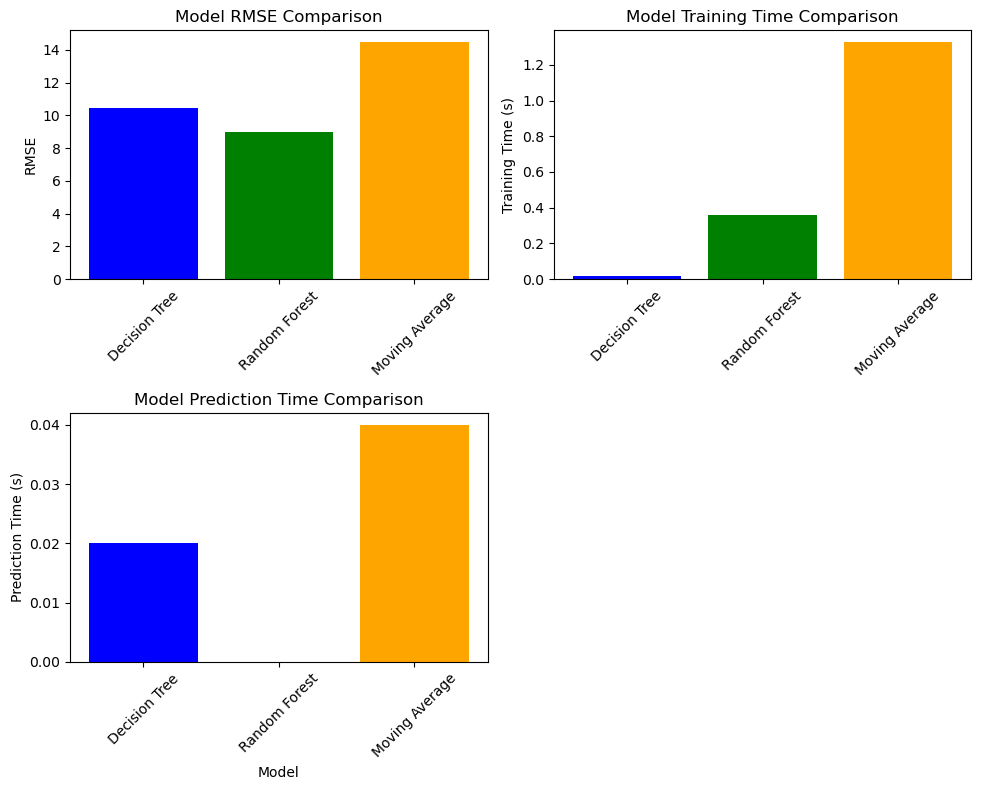

In [43]:
# Compare RMSE, Train and Predict Values

fig, axes = plt.subplots(2, 2, figsize=(10, 8)) 

# RMSE comparison
axes[0, 0].bar(rmse_values.keys(), rmse_values.values(), color=['blue', 'green', 'orange', 'red'])
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_title('Model RMSE Comparison')
axes[0, 0].tick_params(axis='x', rotation=45) 

# Train Time comparison
axes[0, 1].bar(training_times.keys(), training_times.values(), color=['blue', 'green', 'orange', 'red'])
axes[0, 1].set_ylabel('Training Time (s)')
axes[0, 1].set_title('Model Training Time Comparison')
axes[0, 1].tick_params(axis='x', rotation=45) 

# Prediction Time comparison
axes[1, 0].bar(prediction_times.keys(), prediction_times.values(), color=['blue', 'green', 'orange', 'red'])
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('Prediction Time (s)')
axes[1, 0].set_title('Model Prediction Time Comparison')
axes[1, 0].tick_params(axis='x', rotation=45)

# Hide the empty subplot at bottom-right corner
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

Each model exhibits distinct capabilities and constraints. Upon training each model with its optimal parameters and evaluating them with test data, the results reflected patterns observed during training. Additionally there are significant variations in their performance efficiency became evident.

The Decision Tree Model proved to be the quickest during training and maintained a relatively swift prediction speed. Its RMSE value fell in the middle range. In contrast, the Random Forest Model exhibited the lowest RMSE among the three models. Although it trained slightly slower than the Decision Tree Model, it excelled in prediction speed. On the other hand, the Moving Average model, while the slowest to train and possessing the highest RMSE, was surprisingly the fastest when it came to making predictions.

## Conclusion

The primary objective of the project is to achieve a Root Mean Squared Error (RMSE) of less than 48 on the test set. This level of accuracy is crucial for Sweet Lift Taxi to accurately predict shifts in demand, enhancing operational planning and service reliability.

Following an analysis of historical data and exploration of various machine learning algorithms, six models were trained and evaluated based on their RMSE values. Results showed that all models performed closely within a range of ±4.3669, effectively minimizing errors across both training and validation datasets, with none exceeding an RMSE of 48.

Moving forward, the Decision Tree Regressor, Random Forest Regressor, and Moving Average (MA) Model have been selected for further evaluation using test data. Each model demonstrates distinct strengths: the Decision Tree Model offers rapid training and prediction speeds with moderate RMSE, the Random Forest Model excels in prediction accuracy despite slightly slower training, and the Moving Average model provides quick predictions despite a higher RMSE.

By identifying the optimal model based on performance and computational efficiency with test data, Sweet Lift Taxi aims to implement a robust predictive tool. This tool will effectively anticipate fluctuations in demand, enabling strategic decision-making to optimize resource allocation and service delivery during peak hours, thereby enhancing overall service quality and customer satisfaction.